In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X.npy')
y=np.load('data_y.npy')

In [3]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [5]:
from keras import models, layers
from keras import Input
from keras.applications import ResNet50
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

input = Input(shape=(224, 224, 3))
model = ResNet50(input_tensor=input, include_top=False, weights=None)
model.trainable = False
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [6]:
for layer in model.layers:
    layer.trainable=False
    
x = model.output
x=layers.Flatten()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(4, activation='softmax')(x)
additional_model=Model(inputs=model.input, outputs=output)

additional_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [7]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [8]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='ResNet_fine_tuning_2_no callback.hdf5', 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)

In [9]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [10]:
class_weight = {0: 1.1,
                1: 1.1,
                2: 1,
                3: 1}

In [11]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=3, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint],
            class_weight=class_weight)

Epoch 1/3
43/42 [==============================] - 17s 399ms/step - loss: 6.2292 - acc: 0.2476 - auc: 0.5061 - precision: 0.2509 - recall: 0.2291 - f1score: 0.0760 - val_loss: 760.1100 - val_acc: 0.2041 - val_auc: 0.5017 - val_precision: 0.2382 - val_recall: 0.2192 - val_f1score: nan
Epoch 2/3
43/42 [==============================] - 11s 255ms/step - loss: 2.6291 - acc: 0.2922 - auc: 0.5121 - precision: 0.2513 - recall: 0.2273 - f1score: 0.0922 - val_loss: 606.6689 - val_acc: 0.2362 - val_auc: 0.5203 - val_precision: 0.2627 - val_recall: 0.2385 - val_f1score: nan
Epoch 3/3
43/42 [==============================] - 11s 256ms/step - loss: 1.9889 - acc: 0.3287 - auc: 0.5248 - precision: 0.2716 - recall: 0.2419 - f1score: 0.1004 - val_loss: 373.0104 - val_acc: 0.2362 - val_auc: 0.5280 - val_precision: 0.2790 - val_recall: 0.2440 - val_f1score: nan


In [12]:
len(additional_model.layers)

180

In [13]:
for layer in additional_model.layers[:46]:
    layer.trainable=False

for layer in additional_model.layers[46:]:
    layer.trainable=True

In [14]:
for layer in additional_model.layers:
    print(layer, layer.trainable)
    
additional_model.summary()

<keras.engine.input_layer.InputLayer object at 0x000001D88B1035C8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001D88B103048> False
<keras.layers.convolutional.Conv2D object at 0x000001D88B10C488> False
<keras.layers.normalization.BatchNormalization object at 0x000001D8BC369508> False
<keras.layers.core.Activation object at 0x000001D8BC369048> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001D8BC52EA88> False
<keras.layers.pooling.MaxPooling2D object at 0x000001D8C26A5EC8> False
<keras.layers.convolutional.Conv2D object at 0x000001D8C270AD08> False
<keras.layers.normalization.BatchNormalization object at 0x000001D8C2848A08> False
<keras.layers.core.Activation object at 0x000001D8C2848808> False
<keras.layers.convolutional.Conv2D object at 0x000001D8C284DA08> False
<keras.layers.normalization.BatchNormalization object at 0x000001D8C286DD08> False
<keras.layers.core.Activation object at 0x000001D8C28785C8> False
<keras.layers.convolutional.Conv2D objec

C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [15]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [16]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=20, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint],
            class_weight=class_weight)

Epoch 1/20
43/42 [==============================] - 24s 547ms/step - loss: 1.5553 - acc: 0.3426 - auc_1: 0.5981 - precision_1: 0.4014 - recall_1: 0.2261 - f1score: 0.1087 - val_loss: 18.1842 - val_acc: 0.2012 - val_auc_1: 0.5800 - val_precision_1: 0.3649 - val_recall_1: 0.1944 - val_f1score: 0.0578
Epoch 2/20
43/42 [==============================] - 12s 280ms/step - loss: 1.4007 - acc: 0.3587 - auc_1: 0.5830 - precision_1: 0.3588 - recall_1: 0.1743 - f1score: 0.1117 - val_loss: 9.2190 - val_acc: 0.1983 - val_auc_1: 0.5817 - val_precision_1: 0.3471 - val_recall_1: 0.1649 - val_f1score: 0.0612
Epoch 3/20
43/42 [==============================] - 12s 280ms/step - loss: 1.3732 - acc: 0.3981 - auc_1: 0.5856 - precision_1: 0.3491 - recall_1: 0.1631 - f1score: 0.1148 - val_loss: 5.1153 - val_acc: 0.1953 - val_auc_1: 0.5884 - val_precision_1: 0.3483 - val_recall_1: 0.1577 - val_f1score: 0.0683
Epoch 4/20
43/42 [==============================] - 12s 280ms/step - loss: 1.3884 - acc: 0.3601 - auc_

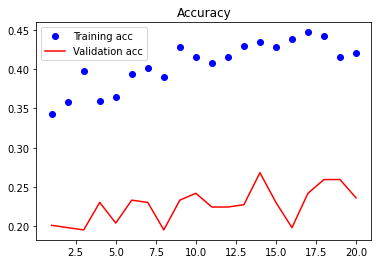

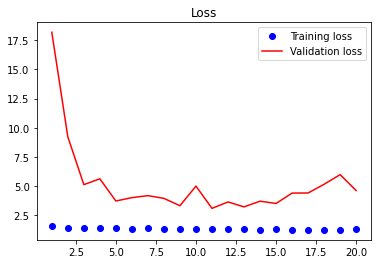

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [18]:
for layer in additional_model.layers:
    layer.trainable=True

In [19]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-6),
              metrics=['acc',tf.keras.metrics.AUC(name='auc'),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=100, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint],
            class_weight=class_weight)

Epoch 1/100
43/42 [==============================] - 31s 711ms/step - loss: 1.1857 - acc: 0.4529 - auc: 0.7493 - precision_2: 0.5651 - recall_2: 0.2314 - f1score: 0.1293 - val_loss: 2.6723 - val_acc: 0.2536 - val_auc: 0.7177 - val_precision_2: 0.4923 - val_recall_2: 0.2200 - val_f1score: 0.0886
Epoch 2/100
43/42 [==============================] - 17s 385ms/step - loss: 1.1564 - acc: 0.4704 - auc: 0.7120 - precision_2: 0.4829 - recall_2: 0.2258 - f1score: 0.1324 - val_loss: 2.6811 - val_acc: 0.2566 - val_auc: 0.7103 - val_precision_2: 0.4803 - val_recall_2: 0.2319 - val_f1score: 0.0893
Epoch 3/100
43/42 [==============================] - 17s 385ms/step - loss: 1.1657 - acc: 0.4653 - auc: 0.7089 - precision_2: 0.4764 - recall_2: 0.2315 - f1score: 0.1314 - val_loss: 2.5531 - val_acc: 0.2566 - val_auc: 0.7071 - val_precision_2: 0.4730 - val_recall_2: 0.2323 - val_f1score: 0.0894
Epoch 4/100
43/42 [==============================] - 17s 386ms/step - loss: 1.1834 - acc: 0.4565 - auc: 0.7058 -

Epoch 29/100
43/42 [==============================] - 17s 386ms/step - loss: 1.1565 - acc: 0.4668 - auc: 0.7446 - precision_2: 0.5346 - recall_2: 0.2336 - f1score: 0.1322 - val_loss: 1.1884 - val_acc: 0.4665 - val_auc: 0.7450 - val_precision_2: 0.5352 - val_recall_2: 0.2337 - val_f1score: 0.1289
Epoch 30/100
43/42 [==============================] - 17s 386ms/step - loss: 1.1643 - acc: 0.4675 - auc: 0.7454 - precision_2: 0.5356 - recall_2: 0.2335 - f1score: 0.1314 - val_loss: 1.1825 - val_acc: 0.4665 - val_auc: 0.7457 - val_precision_2: 0.5359 - val_recall_2: 0.2333 - val_f1score: 0.1291
Epoch 31/100
43/42 [==============================] - 17s 384ms/step - loss: 1.1513 - acc: 0.4668 - auc: 0.7461 - precision_2: 0.5366 - recall_2: 0.2335 - f1score: 0.1323 - val_loss: 1.1907 - val_acc: 0.4869 - val_auc: 0.7464 - val_precision_2: 0.5370 - val_recall_2: 0.2334 - val_f1score: 0.1294
Epoch 32/100
43/42 [==============================] - 17s 384ms/step - loss: 1.1486 - acc: 0.4938 - auc: 0.74

Epoch 57/100
43/42 [==============================] - 17s 385ms/step - loss: 1.1296 - acc: 0.4960 - auc: 0.7575 - precision_2: 0.5540 - recall_2: 0.2391 - f1score: 0.1344 - val_loss: 1.1642 - val_acc: 0.4810 - val_auc: 0.7577 - val_precision_2: 0.5541 - val_recall_2: 0.2391 - val_f1score: 0.1315
Epoch 58/100
43/42 [==============================] - 17s 387ms/step - loss: 1.1487 - acc: 0.4770 - auc: 0.7579 - precision_2: 0.5542 - recall_2: 0.2391 - f1score: 0.1333 - val_loss: 1.2029 - val_acc: 0.4490 - val_auc: 0.7579 - val_precision_2: 0.5542 - val_recall_2: 0.2392 - val_f1score: 0.1287
Epoch 59/100
43/42 [==============================] - 17s 387ms/step - loss: 1.1432 - acc: 0.4748 - auc: 0.7581 - precision_2: 0.5544 - recall_2: 0.2394 - f1score: 0.1339 - val_loss: 1.1934 - val_acc: 0.4781 - val_auc: 0.7581 - val_precision_2: 0.5547 - val_recall_2: 0.2395 - val_f1score: 0.1288
Epoch 60/100
43/42 [==============================] - 17s 385ms/step - loss: 1.1502 - acc: 0.4843 - auc: 0.75

Epoch 85/100
43/42 [==============================] - 17s 387ms/step - loss: 1.1363 - acc: 0.4931 - auc: 0.7637 - precision_2: 0.5629 - recall_2: 0.2447 - f1score: 0.1343 - val_loss: 1.1819 - val_acc: 0.4840 - val_auc: 0.7638 - val_precision_2: 0.5630 - val_recall_2: 0.2448 - val_f1score: 0.1300
Epoch 86/100
43/42 [==============================] - 17s 387ms/step - loss: 1.1300 - acc: 0.4777 - auc: 0.7638 - precision_2: 0.5631 - recall_2: 0.2448 - f1score: 0.1347 - val_loss: 1.1740 - val_acc: 0.4898 - val_auc: 0.7639 - val_precision_2: 0.5631 - val_recall_2: 0.2449 - val_f1score: 0.1308
Epoch 87/100
43/42 [==============================] - 17s 387ms/step - loss: 1.1279 - acc: 0.4872 - auc: 0.7640 - precision_2: 0.5633 - recall_2: 0.2449 - f1score: 0.1350 - val_loss: 1.1851 - val_acc: 0.4636 - val_auc: 0.7641 - val_precision_2: 0.5635 - val_recall_2: 0.2450 - val_f1score: 0.1302
Epoch 88/100
43/42 [==============================] - 17s 387ms/step - loss: 1.1282 - acc: 0.4982 - auc: 0.76

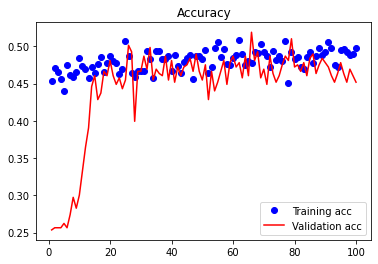

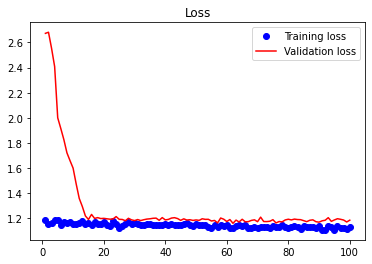

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [21]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

343/343 [==============================] - 1s 3ms/step
loss: 1.186, accuracy: 0.452, auc: 0.766, precision: 0.566, recall: 0.247, f1score: 0.130


In [22]:
import tensorflow as tf

new_model = models.load_model('ResNet_fine_tuning_2_no callback.hdf5',compile=False)

new_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [23]:
_loss, _acc, _auc, _precision, _recall, _f1score =new_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

343/343 [==============================] - 3s 7ms/step
loss: 1.161, accuracy: 0.478, auc: 0.759, precision: 0.591, recall: 0.198, f1score: 0.131


In [24]:
X_test=np.load('X_val.npy')
y_test=np.load('y_val.npy')

In [25]:
_loss, _acc, _auc, _precision, _recall, _f1score =new_model.evaluate(X_test, y_test, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

571/571 [==============================] - 2s 4ms/step
loss: 1.143, accuracy: 0.492, auc: 0.762, precision: 0.556, recall: 0.237, f1score: 0.132
